# Packages

In [60]:
import tensorflow as tf
from tensorflow.keras import models, layers
import pandas as pd
import os
import io
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2024-04-02 11:28:30.865699: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 11:28:30.865804: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 11:28:30.865883: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 11:28:30.865963: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 11:28:30.866043: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 11:28:30.866232: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 11:28:30.866310: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Number of replicas: 8


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 25

print(BATCH_SIZE)

512


# Data Loading

In [4]:
paths = []
labels = []

df = pd.read_csv("/kaggle/input/cassava-leaf-disease-classification/train.csv")

for i in df["image_id"]:
    paths.append(i)

for i in df["label"]:
    labels.append(i)

print(paths[:10])
print(labels[:10])
df

['1000015157.jpg', '1000201771.jpg', '100042118.jpg', '1000723321.jpg', '1000812911.jpg', '1000837476.jpg', '1000910826.jpg', '1001320321.jpg', '1001723730.jpg', '1001742395.jpg']
[0, 3, 1, 1, 3, 3, 2, 0, 4, 3]


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


# No TFRecord Files

In [5]:
# Create a dataset of file paths
image_dataset = tf.data.Dataset.from_tensor_slices(paths)

# Function to load and preprocess each image
def load_and_preprocess(path):
    image = tf.io.read_file("/kaggle/input/cassava-leaf-disease-classification/train_images/" + path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [512, 512])
    return image

# Create image dataset
image_dataset = image_dataset.map(load_and_preprocess)

# Create dataset for labels
label_dataset = tf.data.Dataset.from_tensor_slices(labels)

dataset_no_tfrecord = tf.data.Dataset.zip((image_dataset, label_dataset))


train_split = 0.9
val_split = 0.1

train_num = int(len(labels)*train_split)
val_num = int(len(labels)*val_split)

# make sure to get all the number of training examples in the dataset
if not train_num + val_num == len(labels):
    train_val_num = train_num + val_num
    leftovers = len(labels) - train_val_num
    val_num += leftovers

# sanity check
if train_num + val_num == len(labels):
    print("train_num plus val_num does equal the number of training examples")

if not train_num + val_num == len(labels):
    print("train_num plus val_num does not equal the number of training examples")

train_dataset_no_tfrecord = dataset_no_tfrecord.take(train_num)
val_dataset_no_tfrecord = dataset_no_tfrecord.skip(train_num)

train_num plus val_num does equal the number of training examples


In [6]:
def augment(image, label):
    
    # Apply random contrast
    image = tf.image.random_contrast(image, lower=0.3, upper=0.5)
    
    # Apply random rotation
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    return image, label

train_dataset_no_tfrecord = train_dataset_no_tfrecord.cache().batch(batch_size = BATCH_SIZE).map(augment).map(lambda x, y: (x/255, y)).shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_dataset_no_tfrecord = val_dataset_no_tfrecord.cache().batch(batch_size = BATCH_SIZE).map(augment).map(lambda x, y: (x/255, y)).shuffle(500).prefetch(buffer_size=AUTOTUNE)

print("\nTraining data shapes:", train_dataset_no_tfrecord)
print("\nValidation data shapes:", val_dataset_no_tfrecord)



Training data shapes: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Validation data shapes: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# Model

In [11]:
# mixed-precision training
mixed_precision.set_global_policy('mixed_float16')


with strategy.scope():
    
    model = models.Sequential([layers.Input(shape=(512, 512, 3)),
                               
                               layers.Conv2D(32, kernel_size=(3, 3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Flatten(),
                               layers.Dense(128),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.Dense(5, activation="softmax")])
    
    model.compile(optimizer="adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

I0000 00:00:1712044216.305125      13 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 510, 510, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 510, 510, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             

 Total params: 237,573 (928.02 KB)

 Trainable params: 237,573 (928.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = saved_model.fit(train_dataset_no_tfrecord, epochs=EPOCHS, validation_data=val_dataset_no_tfrecord)

Epoch 1/25


In [ ]:
scores = model.evaluate(test_dataset)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc, label='Training Accuracy')
plt.plot(range(25), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss, label='Training Loss')
plt.plot(range(25), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# ResNet

In [ ]:
# mixed-precision training
mixed_precision.set_global_policy('mixed_float16')

# pre-trained model
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(512, 512, 3),
                                                  pooling='avg',
                                                  weights='imagenet')

pretrained_model.trainable = False

with strategy.scope():
    
    model1 = models.Sequential([pretrained_model,
                             layers.Flatten(),
                             layers.Dense(128),
                             layers.Dropout(0.2),
                             layers.Activation('relu'),
                             layers.Dense(5, activation="softmax")])
    
    model1.compile(optimizer="adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])


In [ ]:
model1.summary()

In [ ]:
history1 = model1.fit(train_dataset_no_tfrecord, epochs=EPOCHS, validation_data=val_dataset_no_tfrecord)

# Saved Model

In [7]:
import shutil

# Define source and destination paths
src_path = r"/kaggle/input/trained_model1.keras/keras/two/1/trained_model2.keras"
dst_path = r"/kaggle/working/"

# Copy the file
shutil.copy(src_path, dst_path)

saved_model = tf.keras.models.load_model('/kaggle/working/trained_model2.keras')

saved_weights = saved_model.get_weights()


import pickle

# Load the weights with pickle
with open('/kaggle/working/trained_model3_weights_dataset_objects.pkl', 'rb') as f:
    loaded_weights = pickle.load(f)

/usr/local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 42 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [8]:
mixed_precision.set_global_policy('mixed_float16')

with strategy.scope():
    
    model = models.Sequential([layers.Input(shape=(512, 512, 3)),
                               
                               layers.Conv2D(32, kernel_size=(3, 3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Flatten(),
                               layers.Dense(128),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.Dense(5, activation="softmax")])
    
    model.set_weights(saved_weights)
    
    model.compile(optimizer="adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

I0000 00:00:1712057343.130023      13 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 510, 510, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 510, 510, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             

 Total params: 237,573 (928.02 KB)

 Trainable params: 237,573 (928.02 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(train_dataset_no_tfrecord, epochs=EPOCHS, validation_data=val_dataset_no_tfrecord)

Epoch 1/25


2024-04-02 11:29:33.836935: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 11:29:33.860390: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 11:29:33.883085: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 11:29:33.905293: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 11:29:33.928919: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 11:29:33.952445: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 11:29:33.974686: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

 2/38 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 5.4883 - loss: 6.6517      

2024-04-02 11:33:05.597321: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


 7/38 ━━━━━━━━━━━━━━━━━━━━ 1:38 3s/step - accuracy: 5.7100 - loss: 6.1817

2024-04-02 11:33:23.249443: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 5.8597 - loss: 5.8434

2024-04-02 11:34:07.828289: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.
2024-04-02 11:34:28.357143: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 5.7284 - loss: 5.7121 - val_accuracy: 0.7687 - val_loss: 0.6601
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 6.2730 - loss: 4.8395

2024-04-02 11:38:53.566635: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 6.1324 - loss: 4.7308 - val_accuracy: 0.7500 - val_loss: 0.6694
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 6.2232 - loss: 4.4904 - val_accuracy: 0.7425 - val_loss: 0.6680
Epoch 4/25


2024-04-02 11:46:47.469892: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 6.2270 - loss: 4.4817 - val_accuracy: 0.7761 - val_loss: 0.6386
Epoch 5/25


2024-04-02 11:51:41.212434: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 6.1946 - loss: 4.4135 - val_accuracy: 0.7985 - val_loss: 0.6563
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 6.4071 - loss: 4.3780

2024-04-02 11:57:27.861633: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 6.2630 - loss: 4.2800 - val_accuracy: 0.7687 - val_loss: 0.6667
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 6.2800 - loss: 4.2559 - val_accuracy: 0.7836 - val_loss: 0.6123
Epoch 8/25
35/38 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 6.4231 - loss: 4.3489

2024-04-02 12:06:30.561713: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 6.2797 - loss: 4.2506 - val_accuracy: 0.7649 - val_loss: 0.6638
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 6.3109 - loss: 4.1808 - val_accuracy: 0.7612 - val_loss: 0.7058
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 6.3538 - loss: 4.0533 - val_accuracy: 0.7836 - val_loss: 0.6362
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 6.3462 - loss: 4.1009 - val_accuracy: 0.7537 - val_loss: 0.6618
Epoch 12/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 6.3552 - loss: 4.0148 - val_accuracy: 0.7649 - val_loss: 0.6789
Epoch 13/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 6.4111 - loss: 3.9548 - val_accuracy: 0.7276 - val_loss: 0.7744
Epoch 14/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 6.4066 - loss: 3.8695 - val_accuracy: 0.7575 - val_loss: 0.7073
Epoch 15/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 6.4127 - loss: 3.8310 - val_accuracy: 0.7799 - val_lo

In [11]:
model.evaluate(val_dataset_no_tfrecord)

5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 966ms/step - accuracy: 5.3447 - loss: 4.0867


[0.6278253793716431, 0.7873134613037109]

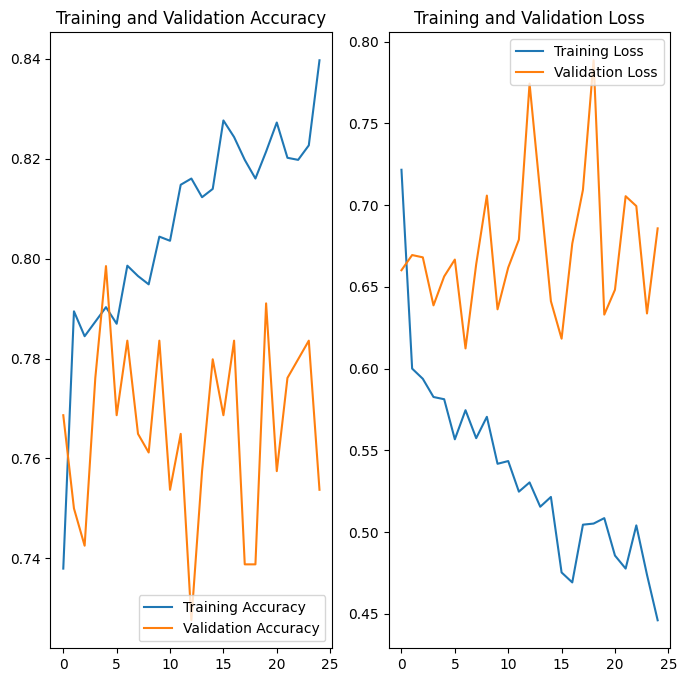

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc, label='Training Accuracy')
plt.plot(range(25), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss, label='Training Loss')
plt.plot(range(25), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
accuracy = [accuracy for accuracy in history.history["accuracy"]]
val_accuracy = [val_accuracy for val_accuracy in history.history["val_accuracy"]]

both = zip(accuracy, val_accuracy)

for acc, val_acc in both:
    print(f"{acc}, {val_acc}")


import csv

with open("trained_model3_acc", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(accuracy)

with open("trained_model3_val_acc", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(val_accuracy)
    
    
print(accuracy)

print("\n", val_accuracy)

[0.7379568219184875, 0.7894518375396729, 0.784468412399292, 0.7873753905296326, 0.7902823686599731, 0.7869601249694824, 0.7985880374908447, 0.7965116500854492, 0.7948504686355591, 0.8044019937515259, 0.8035714030265808, 0.814784049987793, 0.8160299062728882, 0.8122923374176025, 0.8139534592628479, 0.8276578187942505, 0.8243355751037598, 0.819767415523529, 0.8160299062728882, 0.8214285969734192, 0.8272425532341003, 0.820182740688324, 0.819767415523529, 0.8226743936538696, 0.8397009968757629]

 [0.7686567306518555, 0.75, 0.7425373196601868, 0.7761194109916687, 0.7985074520111084, 0.7686567306518555, 0.7835820913314819, 0.7649253606796265, 0.7611940503120422, 0.7835820913314819, 0.753731369972229, 0.7649253606796265, 0.7276119589805603, 0.7574626803398132, 0.7798507213592529, 0.7686567306518555, 0.7835820913314819, 0.7388059496879578, 0.7388059496879578, 0.7910447716712952, 0.7574626803398132, 0.7761194109916687, 0.7798507213592529, 0.7835820913314819, 0.753731369972229]


# Scratch

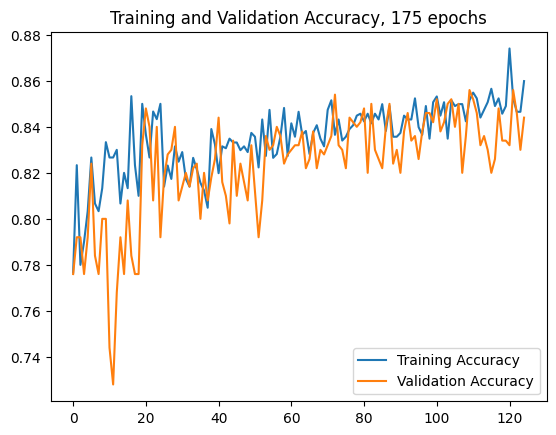

In [61]:
with open("/kaggle/input/d/edmundmacalalag/accuracies/trained_model3_acc_&_val_acc_75_epochs/trained_model3_acc_multiple_datasets.txt", "r") as f:
    acc_3 = f.readlines()

with open("/kaggle/input/d/edmundmacalalag/accuracies/trained_model3_acc_&_val_acc_75_epochs/trained_model3_val_acc_multiple_datasets.txt", "r") as f:
    val_acc_3 = f.readlines()

acc_3 = acc_3[0].split(", ")
val_acc_3 = val_acc_3[0].split(", ")

acc_3 = [float(a) for a in acc_3]
val_acc_3 = [float(v) for v in val_acc_3]


with open("/kaggle/input/d/edmundmacalalag/accuracies/trained_model4_acc_&_val_acc_100_epochs/trained_model4_acc_multiple_datasets.txt", "r") as f:
    acc_4 = f.readline()

with open("/kaggle/input/d/edmundmacalalag/accuracies/trained_model4_acc_&_val_acc_100_epochs/trained_model4_val_acc_multiple_datasets.txt", "r") as f:
    val_acc_4 = f.readline()

acc_4 = acc_4[2:-2]
val_acc_4 = val_acc_4[2:-2]

acc_4 = acc_4.split("], [")
val_acc_4 = val_acc_4.split("], [")


acc_4 = [float(i) for i in acc_4]
val_acc_4 = [float(i) for i in val_acc_4]


with open("/kaggle/input/d/edmundmacalalag/accuracies/trained_model5_acc_&_val_acc_125_epochs/trained_model5_acc_multiple_datasets", "r") as f:
    acc_5 = f.readlines()
    
with open("/kaggle/input/d/edmundmacalalag/accuracies/trained_model5_acc_&_val_acc_125_epochs/trained_model5_val_acc_multiple_datasets", "r") as f:
    val_acc_5 = f.readlines()

acc_5 = [float(i[:-2]) for i in acc_5]
val_acc_5 = [float(i[:-2]) for i in val_acc_5]


with open("/kaggle/input/d/edmundmacalalag/accuracies/trained_model6_acc_&_val_acc_150_epochs/trained_model6_acc_multiple_datasets", "r") as f:
    acc_6 = f.readlines()
    
with open("/kaggle/input/d/edmundmacalalag/accuracies/trained_model6_acc_&_val_acc_150_epochs/trained_model6_val_acc_multiple_datasets", "r") as f:
    val_acc_6 = f.readlines()

acc_6 = [float(i[:-2]) for i in acc_6]
val_acc_6 = [float(i[:-2]) for i in val_acc_6]


with open("/kaggle/input/d/edmundmacalalag/accuracies/trained_model7_acc_&_val_acc_175_epochs/trained_model7_acc_multiple_datasets", "r") as f:
    acc_7 = f.readlines()
    
with open("/kaggle/input/d/edmundmacalalag/accuracies/trained_model7_acc_&_val_acc_175_epochs/trained_model7_val_acc_multiple_datasets", "r") as f:
    val_acc_7 = f.readlines()

acc_7 = [float(i[:-2]) for i in acc_7]
val_acc_7 = [float(i[:-2]) for i in val_acc_7]


acc = acc_3 + acc_4 + acc_5 + acc_6 + acc_7

val_acc = val_acc_3 + val_acc_4 + val_acc_5 + val_acc_6 + val_acc_7



plt.plot(range(125), acc, label='Training Accuracy')
plt.plot(range(125), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy, 175 epochs')
plt.show()

# TFRecords

### Writing to TFRecord File

In [ ]:
# with tf.io.TFRecordWriter("train_tfrecords") as writer:
    
#     for path, label in zip(paths, labels):
        
#         # open the image metadata using the filepath. The image itself here isn't loaded, only the metadata
#         image = Image.open("/kaggle/input/cassava-leaf-disease-classification/train_images/" + str(path))
        
#         bytes_buffer = io.BytesIO() # create an in-memory temporary storage
#         image.resize((512, 512)) # the images are actually 600 x 800. However, the competition chose (512, 512) instead.
#         image.convert("RGB").save(bytes_buffer, "JPEG") # convert the image to RGB, save it to the in-memory storage as JPEG
#         image_bytes = bytes_buffer.getvalue() # get the bytes string
        
#         # create the feature for image and its label
#         bytes_feature = tf.train.Feature(bytes_list = tf.train.BytesList(value=[image_bytes]))
#         class_feature = tf.train.Feature(int64_list = tf.train.Int64List(value=[label]))
        
#         # zip them into an example
#         example = tf.train.Example(features = tf.train.Features(feature = {"image": bytes_feature,
#                                                                            "class": class_feature}))
        
#         # write into the tfrecord file
#         writer.write(example.SerializeToString())
        
#         image.close()

### Reading from TFRecord File

In [15]:
# # create dictionary so that tensorflow knows what to expect of the image's and label's data type when parsing them
# image_feature_description = {"image": tf.io.FixedLenFeature([], tf.string),
#                              "class": tf.io.FixedLenFeature([], tf.int64)}

# # parse the tfrecord file
# def parse_data(unparsed_example):
#     return tf.io.parse_single_example(unparsed_example, image_feature_description)

# # decode and convert the image to tensor
# def bytestring_to_pixels(parsed_example):
#     byte_string = parsed_example["image"]
#     image = tf.io.decode_image(byte_string)
#     return image, parsed_example["class"]

# # create the dataset object using the tfrecord file, not the actual raw image files
# def load_and_extract_images(filepath):
#     dataset = tf.data.TFRecordDataset(filepath) # dataset object for tfrecord files
#     dataset = dataset.map(parse_data, num_parallel_calls=AUTOTUNE)
#     dataset = dataset.map(bytestring_to_pixels, num_parallel_calls=AUTOTUNE)
#     return dataset

# dataset = load_and_extract_images("/kaggle/input/train-tfrecords/train_tfrecords")

# Train-Test Split

### Train and Val Split

In [ ]:
# # Notes on dataset objects:
# # 1. Each element of a dataset object may contain one or numerous training example. By default, it contains one training example per element. However, if i set the batch size to 32, then training examples per element is also 32
# # 2. Dataset objects are defaulted to a batch size of 1 (i.e., one training example per element). The batch size determines the number of training examples per element
# # 3. In dataset objects, for each training example, it is composed of image, label pair
# # 4. If you use the .take() method, it takes each element and not each training example
# # 5. To iterate over dataset objects, consider the code below. You always need to use .as_numpy_iterator() on the dataset object (or .numpy()) to display it as a numpy array

# #                                                 for image, label in dataset.take(3).as_numpy_iterator():
# #                                                     print(image, label)

# #                                                                        or

# #                                                 for image, label in dataset.take(3):
# #                                                     print(image.numpy(), label.numpy())

# # 6. In the first iteration (first element) of the code provided, it prints the label in list format which contains the labels for all training examples in that first element. Similarly, for the image, it prints the numpy arrays of all the training examples within that element in list format.


# # split

# train_split = 0.9
# val_split = 0.1

# train_num = int(len(labels)*train_split)
# val_num = int(len(labels)*val_split)

# # make sure to get all the number of training examples in the dataset
# if not train_num + val_num == len(labels):
#     train_val_num = train_num + val_num
#     leftovers = len(labels) - train_val_num
#     val_num += leftovers

# # sanity check
# if train_num + val_num == len(labels):
#     print("train_num plus val_num does equal the number of training examples")

# if not train_num + val_num == len(labels):
#     print("train_num plus val_num does not equal the number of training examples")

# train_dataset = dataset.take(train_num)
# val_dataset = dataset.skip(train_num)

# # Notes:
# # 1. When the dataset object has 1 training example per element, the value that you need to pass to .take() is according to the total number of training examples
# # 2. When the dataset object has, for example, 1000 elements (each of which has 32 training examples), and the value you passed to the take method is 10000 training examples, it gets all the elements. Hence, the val_dataset (using skip method) becomes empty.
# # 3. The dataset object contains image, label pairs. Apply the normalization to the image only
# # 4. The .cache method should be called before other computationally expensive methods like data augmentation, and the .prefetch method should be called at the end of the pipeline
# train_dataset = train_dataset.cache().batch(batch_size = BATCH_SIZE).map(lambda x, y: (x/255, y)).map(lambda x, y: (tf.image.resize(x, [512, 512]), y)).shuffle(2048).prefetch(buffer_size=AUTOTUNE)
# val_dataset = val_dataset.cache().batch(batch_size = BATCH_SIZE).map(lambda x, y: (x/255, y)).map(lambda x, y: (tf.image.resize(x, [512, 512]), y)).shuffle(2048).prefetch(buffer_size=AUTOTUNE)

# print("\nTraining data shapes:", train_dataset)
# print("\nValidation data shapes:", val_dataset)

### Test Split

In [ ]:
# # our test data is only one image with no label. Kaggle has already created a tfrecord file for this test data; we only need to parse and decode it

# # create dictionary so that tensorflow knows what to expect of the image's and label's data type when parsing them
# image_feature_description_test_data = {"image": tf.io.FixedLenFeature([], tf.string)}

# # parse the tfrecord file
# def parse_test_data(unparsed_example):
#     return tf.io.parse_single_example(unparsed_example, image_feature_description_test_data)

# # decode and convert the image to tensor
# def bytestring_to_pixels_test_data(parsed_example):
#     byte_string = parsed_example["image"]
#     image = tf.io.decode_image(byte_string)
#     image = tf.image.resize(image, [512, 512])
#     return image

# # create the dataset object using the tfrecord file, not the actual raw image files
# def load_and_extract_images_test_data(filepath):
#     dataset = tf.data.TFRecordDataset(filepath) # dataset object for tfrecord files
#     dataset = dataset.map(parse_test_data, num_parallel_calls=AUTOTUNE)
#     dataset = dataset.map(bytestring_to_pixels_test_data, num_parallel_calls=AUTOTUNE)
#     return dataset

# test_dataset = load_and_extract_images_test_data("/kaggle/input/cassava-leaf-disease-classification/test_tfrecords/ld_test00-1.tfrec")
# test_dataset = test_dataset.cache(filename="cache_test_dataset").batch(batch_size = BATCH_SIZE).map(lambda x: (x/255)).shuffle(2048).prefetch(buffer_size=AUTOTUNE)